This notebook is to do some more itk filterting and find the peaks in the diffraction patterns 
and transform them into 3D

In [1]:
#use this for interactive pop up images
#%matplotlib qt5

In [96]:
import hyperspy.api as hs
import pyxem as pxm
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
import pandas as pd
import time
import gc
import os
from os.path import exists
from skimage.transform import resize
from ipywidgets import IntProgress
from IPython.display import display

In [92]:
#load one calibrated 4dstem for testing
#output path is from TomoCalibrationPreProcess.ipynb

outpath = 'D:/data/August2022/TiNi/tomo/Tomo_23/post/'
inpath = outpath
dp = hs.load(inpath + '4DSTEM2_0.hdf5',lazy=True)
dp.set_signal_type('electron_diffraction')

In [101]:
# test the itk filters on one 4dstem image
# rebin the DP signal axes with 2 

dp_binned_s = hs.signals.Signal2D(np.zeros( (dp.data.shape[0],dp.data.shape[1], int(dp.data.shape[2]/ 2),int(dp.data.shape[3]/ 2))),lazy=True)
dp_binned_s.set_signal_type('electron_diffraction')

max_count = dp.data.shape[0]*dp.data.shape[1]
f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar

lf = sitk.LaplacianSharpeningImageFilter()
WHF = sitk.WhiteTopHatImageFilter()
WHF.SetKernelRadius (7)
WHF.SetSafeBorder (True)
MMCF = sitk.MinMaxCurvatureFlowImageFilter()
        
for j in range(dp.data.shape[0]): 

    for i in range(dp.data.shape[1]): 
        
        f.value += 1 # signal to increment the progress bar
        #dp1 = dp.data[j,i,:,:]
        dp1 = resize(dp.data[j,i,:,:], (dp.data.shape[2] / 2, dp.data.shape[3] / 2), anti_aliasing=True)
        dp1 = dp1.astype('float64')
        dp1 *= 1 / dp1.max()
        
        img = sitk.GetImageFromArray(dp1)

        img = MMCF.Execute(img)
        img = lf.Execute(img)
        img = WHF.Execute(img)

        dp_binned_s.data[j,i,:,:] = sitk.GetArrayFromImage(img)
        #dp.data[j,i,:,:] = sitk.GetArrayFromImage(img).astype('float32')
del dp
gc.collect()

IntProgress(value=0, max=2440)

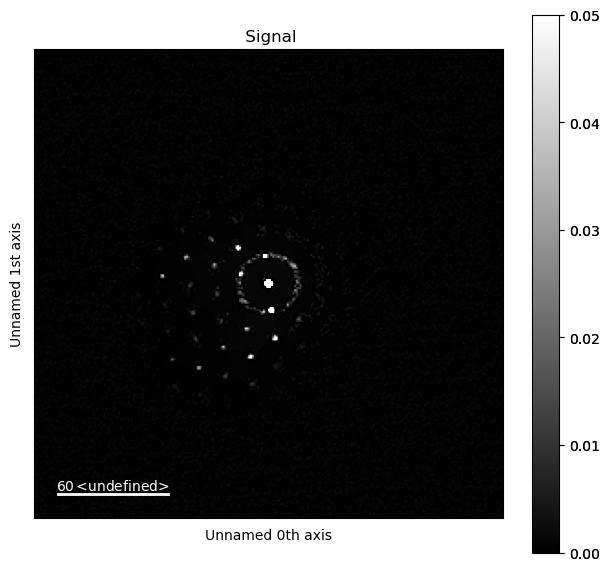

In [102]:
dp_binned_s.inav[22,49].plot(cmap='gray', vmin=0,vmax=0.05 )

[########################################] | 100% Completed | 11.8s


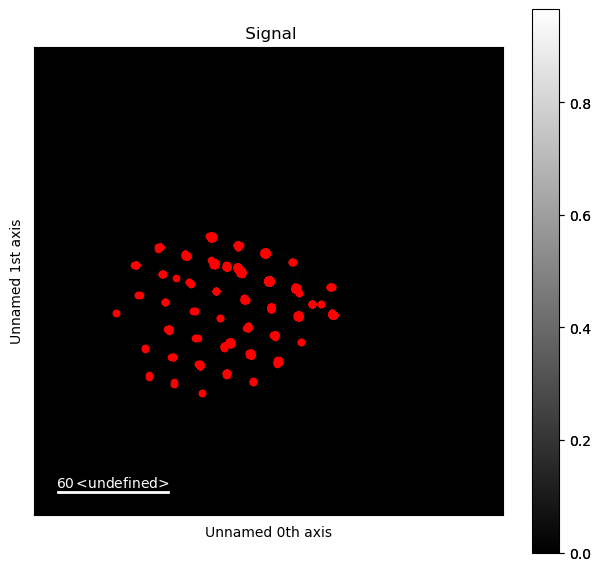

In [103]:
# Find the correct settings for the peak finding algorithm

peak_array = dp.as_lazy().find_peaks_lazy(min_sigma=1., max_sigma=6., sigma_ratio=1.6,threshold=0.1, overlap=0.99 )# min_sigma=5.6, max_sigma=22, sigma_ratio=2.2,threshold=0.1, overlap=0.5
peak_array_computed = peak_array.compute(show_progressbar=False)
dp.add_peak_array_as_markers(peak_array_computed)
peak_array_int = dp.intensity_peaks(peak_array_computed,disk_r=3, lazy_result=False)

dp.inav[22,49].plot(cmap='gray',norm='auto' ) #too many peaks

In [119]:
#functions for removing peaks that are too close to each other

def reduce_tail(l, inte, index,threshold=1):

    elm = l[index]
    mask = np.linalg.norm(elm-l, axis=1) > threshold
    mask[:index+1] = True

    if mask.sum() < l.shape[0]:
        min1 = np.where(inte ==  np.minimum( inte[np.where(~mask)], inte[index]) )
        mask[:] = True
        
        if len(min1[0]) > 1:
            mask[min1[0][1]] = False
        else:
            mask[min1[0]] = False
            
    return l[mask], inte[mask]

def reduce(z, inte,threshold=1):
    zz = np.array(z)
    inte1 = np.array(inte)
    index = 0
    while True:
        zz,inte1 = reduce_tail(zz, inte1, index, threshold)

        index += 1
        if index == zz.shape[0]:
            break
    return zz, inte1

In [ ]:
# Do the ITK filtering and peak search for all 4dstem tilt series
# Change the output path here
# This operation will take hours

outpath2 = 'D:/data/August2022/TiNi/tomo/Tomo_23/post2/'
Ntilts = 70
threshold = 5 # remove lower intesity peak if closer to another one with a distance than this value in pixels

t = time.time()

#peak arrays
peak_array_computed_cut = np.empty((Ntilts,dp.data.shape[0],dp.data.shape[1]), dtype=object)
peak_array_int_cut      = np.empty((Ntilts,dp.data.shape[0],dp.data.shape[1]), dtype=object)

f = IntProgress(min=0, max=Ntilts) # instantiate the bar
display(f) # display the bar
    
lf = sitk.LaplacianSharpeningImageFilter()
WHF = sitk.WhiteTopHatImageFilter()
                
WHF.SetKernelRadius (7)
WHF.SetSafeBorder (True)
MMCF = sitk.MinMaxCurvatureFlowImageFilter()

for tilt in range(Ntilts):
    
    print(tilt)
    test = '4DSTEM_' + str(tilt)
    dp = hs.load(inpath + test +  '.hdf5',lazy=True)
    
    dp_binned_s = hs.signals.Signal2D(np.zeros( (dp.data.shape[0],dp.data.shape[1], int(dp.data.shape[2]/ 2),int(dp.data.shape[3]/ 2))),lazy=True)
    dp_binned_s.set_signal_type('electron_diffraction')

    f.value += 1 # signal to increment the progress bar
            
    for j in range(dp.data.shape[0]):
        for i in range(dp.data.shape[1]):

            dp1 = resize(dp.data[j,i,:,:], (dp.data.shape[2] / 2, dp.data.shape[3] / 2), anti_aliasing=True)
            #dp1 = dp.data[j,i,:,:]
            dp1 = dp1.astype('float64')
            dp1 *= 1 / dp1.max()

            img = sitk.GetImageFromArray(dp1.data)

            img = MMCF.Execute(img)
            img = lf.Execute(img)
            img = WHF.Execute(img)

            dp_binned_s.data[j,i,:,:] = sitk.GetArrayFromImage(img)
            
      
    test = '4DSTEM2_' + str(tilt)
    dp_binned_s.save(outpath2 + test + '.hdf5', overwrite=True)
  
    peak_array = dp_binned_s.as_lazy().find_peaks_lazy(min_sigma=1, max_sigma=6, sigma_ratio=1.6,threshold=0.1, overlap=0.99 )
    
    peak_array_computed = peak_array.compute(show_progressbar=False)
    peak_array_computed1 = dp_binned_s.peak_position_refinement_com(peak_array_computed, lazy_result=False, show_progressbar=False)

    peak_array_int = dp_binned_s.intensity_peaks(peak_array_computed1,disk_r=1, lazy_result=False)

    for j in range(dp_binned_s.data.shape[0]):
        for i in range(dp_binned_s.data.shape[1]):

            peak_array_ints = peak_array_int[j,i]
            pc, pi  = reduce(peak_array_computed1[j,i],peak_array_ints[:,2], threshold)
            peak_array_computed_cut[tilt,j,i] = pc
            peak_array_int_cut[tilt,j,i] = pi
    
    del pc
    del pi
    del peak_array_ints
    del peak_array_int
    del peak_array_computed
    del peak_array_computed1
    del peak_array
    del dp
    del dp_binned_s
    gc.collect()
        
        
test1 = 'peaks'
path = outpath2 + 'peaks/' 
os.makedirs(path, exist_ok=True)

if exists(path):
    with open('{}.npy'.format(path+ test1), 'wb') as f:
        np.save(f, peak_array_computed_cut)
else:
    np.save(path + test1, peak_array_computed_cut)
        

test2 = 'peakints' 

if exists(path):
    with open('{}.npy'.format(path+ test2), 'wb') as f:
        np.save(f, peak_array_int_cut)
else:
    np.save(path+ test2, peak_array_int_cut)

   
elapsed = time.time() - t
elapsed

In [ ]:
# Transform the 2D peaks into 3D using the goniometer tilt angle
# Change the minimum tilt angle amd tilt step

minangle = -64
tiltstep = 2
Ntilts = 70

test = '4DSTEM2_' + str(0)
dp = hs.load(outpath2  + test +  '.hdf5',lazy=True)

Ntilts = 70
peak_array_3d = np.empty((Ntilts,dp.data.shape[0],dp.data.shape[1]), dtype=object)

test1 = 'peaks' 
test2 = 'peakints'
test3 = 'peaks3d'
path = outpath2 + 'peaks/'

with open(path + test1 + '.npy', 'rb') as f:
    pc = np.load(f,allow_pickle=True)
    
with open(path + test2 + '.npy', 'rb') as f:
    pi = np.load(f,allow_pickle=True)
    
peak_array_3d = np.empty((Ntilts,dp.data.shape[0],dp.data.shape[1]), dtype=object)

for l in range(Ntilts):
    
    for j in range(dp.data.shape[0]):
        for i in range(dp.data.shape[1]):

            peaks = pc[l,j,i]
            ints = pi[l,j,i]
            peaks3d = np.zeros((peaks.shape[0],5), dtype = float)
            
            for k in range(peaks.shape[0]):

                Ctilt = minangle + (tiltstep*l)

                y = peaks[k,0] - peaks[0,0]
                x = peaks[k,1] - peaks[0,1]

                v = [y, x, 0]
                axis = [1, 0, 0]
                theta = Ctilt*(np.pi/180)

                axis = axis / norm(axis)  # normalize the rotation vector first
                rot = Rotation.from_rotvec(theta * axis)

                new_v = rot.apply(v)

                new_v[0] = round(new_v[0],2)
                new_v[1] = round(new_v[1],2)
                new_v[2] = round(new_v[2],2)
                
                peaks3d[k,0:3] = new_v
                peaks3d[k,3] = np.linalg.norm(new_v)
                peaks3d[k,4]   = ints[k]
                
                #if peaks3d[k,3] > 1:
                    #print('l',l,'j',j,'i',i,'k',k,'c',peaks3d[k,3])

            peak_array_3d[l,j,i] = peaks3d
                


test1 = 'peaks3d'
path = outpath2 + 'peaks/'  
os.makedirs(path, exist_ok=True)

if exists(path):
    with open('{}.npy'.format(path+ test1), 'wb') as f:
        np.save(f, peak_array_3d)
else:
    np.save(path+ test1, peak_array_3d)
    